In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.io.parsers.read_csv("insurance.csv")

In [3]:
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
pd.DataFrame.duplicated(dataset).value_counts()

False    1337
True        1
Name: count, dtype: int64

In [6]:
dataset.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Data requires no further preprocessing except using one-hot encoding of the categorical variables

In [32]:
df=pd.get_dummies(dataset, dtype=int)

In [33]:
#df=df.sample(frac=1)

In [34]:
stop=round(len(df.index)*.80)
Xtrain=df.iloc[:stop]
Xtest=df.iloc[stop+1:]
Ytrain=Xtrain["charges"]
Ytest=Xtest["charges"]
Xtrain=Xtrain.drop("charges", axis=1)
Xtest=Xtest.drop("charges", axis=1)

Now some linear algebra is required, so the dataframes are converted to numpy arrays

In [35]:
x=Xtrain.to_numpy()
y=Ytrain.to_numpy()
xtest=Xtest.to_numpy()
ytest=Ytest.to_numpy()

Using a linear function $y=\boldsymbol x^\top\boldsymbol\theta$, the likelihood is given by
$$
p(\mathcal Y|\mathcal X,\boldsymbol\theta)=p(y_1,...,y_N|\boldsymbol x_1,...,\boldsymbol x_N,\boldsymbol\theta)=\prod_{n=1}^Np(y_n|\boldsymbol x_n,\boldsymbol\theta)
$$
I assumed that the measurement noise is Gaussian (resulting in a likelihood that is Guassian thus allowing me to compute the gradient explicitly). Minimizing the negative log-likelihood results in
$$
\boldsymbol\theta_{ML}=(\boldsymbol X^\top\boldsymbol X)^{-1}\boldsymbol X^\top\boldsymbol y
$$
but I added $\kappa I_D$ for numerical stability (see below)

In [39]:
def parameter(X,Y):
    N,D=X.shape
    kappa=1e-8
    I_D=np.identity(D)
    X_inv=np.linalg.inv(X.T@X+kappa*I_D) 
    return X_inv@X.T@Y 

Finally, to obtain some measure of performance, I calculate the root mean square loss
$$
\sqrt{\frac1{N}\sum_{n=1}^N(y_n-\boldsymbol x_n^\top\boldsymbol\theta)^2}
$$
and provide some visualization that show how off the predictions are

In [40]:
def RMSE(y,pred):
    N=y.shape[0]
    s=sum(np.power(y-pred,2))
    return np.sqrt(s/N)

In [41]:
theta=parameter(x,y)
pred=xtest@theta
RMSE(ytest,pred)

np.float64(6094.250695615778)

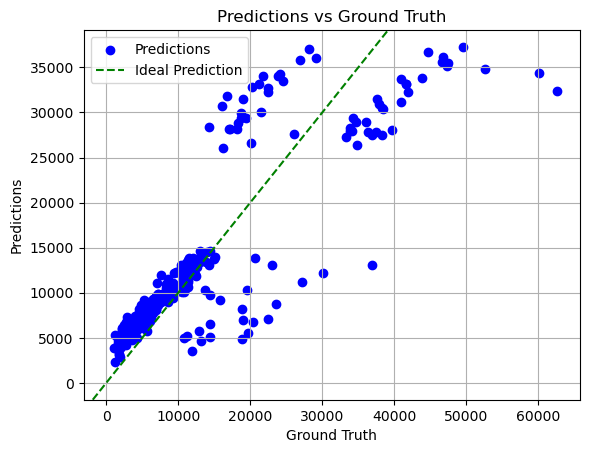

In [31]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(ytest, pred, color="blue", label="Predictions")
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground Truth')
plt.axline((0, 0), slope=1, color='green', linestyle='--', label='Ideal Prediction')  
plt.legend()
plt.grid()
plt.show()

As seen from this graph, most datapoints involve lower charges, so the model tends towards lower values in general, resulting in more accurate predictions. Consequently, it fails at more extreme charges (its highest prediction is below 40k)